In [416]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

from astropy.io import fits

In [417]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

In [426]:
L = 8

L1 = 4
Nbc = 5e28*4.149e-15

p = 2.4e-6



polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lam, plam = np.array([5e-10]), np.ones(1)
# lam, plam = polyspectrum

h = pi/2 / (Nbc*lam[np.argmax(plam)])
phi = Nbc*lam*h
mt = 5
x0 = np.array([0])



camsize = 1.5e-2



xbin = 1e-6
ybin = 1e-6
res = 100e-6
slit = 100e-6
dp2overlam = p**2/lam[np.argmax(plam)]


sgp_vals = np.array([1.5,1])*L*lam[np.argmax(plam)]/p

d = np.linspace(5, 18, 131)*1e-3


G1sd = {"p":p, "L1": np.array([L1]), "phi":phi, "mt": mt, "spectrum_spacing":1}
G1sd["L2"] = d



G2sd = {"p":p, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi, "mt": mt, "spectrum_spacing":1}
G2sd["L2"] = L - (G1sd["L1"] + G1sd["L2"])



simapts = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}
# siminit = {"lam":lam, "plam": plam, "sum_lam":False,"L":L,"d":G1sd["L2"],"mt":mt, "source_period":sgp_vals[1],"duty_cycle": 0.5,\
#             "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
#             "resx": res,"resy": res, "batches" : 1000}

# siminit = {"lam":lam, "plam": plam, "sum_lam":False,"L":L,"d":G1sd["L2"],"mt":mt, "slitx":slit,\
#             "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
#             "resx": res,"resy": res, "batches" : 1000}


In [427]:
t0 = time()

sum_lam = False

siminit = {"lam":lam, "plam": plam, "sum_lam":sum_lam,"L":L,"d":G1sd["L2"],"mt":mt, "source_period":sgp_vals[0],"duty_cycle": 0.5,\
            "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
            "resx": res,"resy": res, "batches" : 1000}
sim = PGMI(simapts,siminit)

sim.propagate_to("G1")
sim.propagate_to("G2")
sim.generate_after("G2")

contp2350 = sim.get_value("contrast")

siminit = {"lam":lam, "plam": plam, "sum_lam":sum_lam,"L":L,"d":G1sd["L2"],"mt":mt, "source_period":sgp_vals[0],"duty_cycle": 0.1,\
            "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
            "resx": res,"resy": res, "batches" : 1000}
sim = PGMI(simapts,siminit)

sim.propagate_to("G1")
sim.propagate_to("G2")
sim.generate_after("G2")
contp2310 = sim.get_value("contrast")

siminit = {"lam":lam, "plam": plam, "sum_lam":sum_lam,"L":L,"d":G1sd["L2"],"mt":mt, "source_period":sgp_vals[1],"duty_cycle": 0.5,\
            "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
            "resx": res,"resy": res, "batches" : 1000}
sim = PGMI(simapts,siminit)

sim.propagate_to("G1")
sim.propagate_to("G2")
sim.generate_after("G2")

contp50 = sim.get_value("contrast")

siminit = {"lam":lam, "plam": plam, "sum_lam":sum_lam,"L":L,"d":G1sd["L2"],"mt":mt, "source_period":sgp_vals[1],"duty_cycle": 0.1,\
            "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
            "resx": res,"resy": res, "batches" : 1000}
sim = PGMI(simapts,siminit)

sim.propagate_to("G1")
sim.propagate_to("G2")
sim.generate_after("G2")
contp10 = sim.get_value("contrast")


siminit = {"lam":lam, "plam": plam, "sum_lam":sum_lam,"L":L,"d":G1sd["L2"],"mt":mt, "slitx":slit,\
            "x" : np.linspace(-camsize/2,camsize/2,int(camsize/xbin)+1),"xbin":xbin,"ybin":ybin,"p":p ,"camsize" : camsize ,"convmode" : "valid",\
            "resx": res,"resy": res, "batches" : 1000}
sim = PGMI(simapts,siminit)

sim.propagate_to("G1")
sim.propagate_to("G2")
sim.generate_after("G2")

contenvel = sim.get_value("contrast")



print(time() - t0, "seconds")




19.33474087715149 seconds


In [428]:
dlamarr = np.array([2/3,1,4/3])*dp2overlam*1e3
# dlamlabels = [r"$\frac{2p^{2}}{3\lambda_c}$", r"$\frac{p^{2}}{\lambda_c}$", r"$\frac{4p^{2}}{3\lambda_c}$" ]
dlamlabels = [r"$\frac{2p^{2}}{3\lambda}$", r"$\frac{p^{2}}{\lambda}$", r"$\frac{4p^{2}}{3\lambda}$" ]

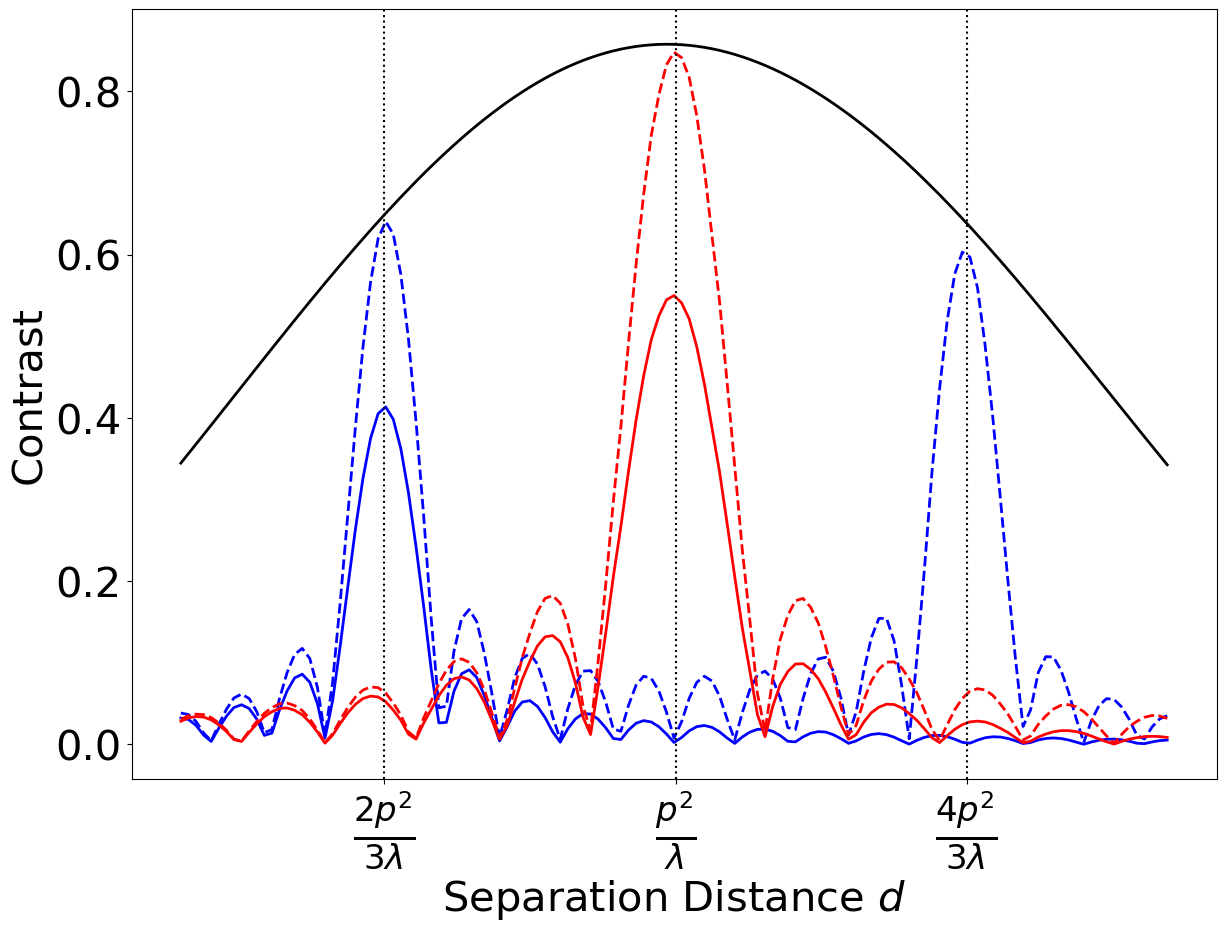

In [430]:
fig, ax1 = plt.subplots(figsize = (14,10))


ax1.set_prop_cycle(color = ["blue","blue","black"])

ax1.plot(sim.d*1e3, contp2350, lw = 2, label = r"DC = .5, $p_s = p_m \,[d = \frac{2p^{2}}{3\lambda}]$" % (sgp_vals[0] / (L*p/dp2overlam)) )
ax1.plot(sim.d*1e3, contp2310, "--", lw = 2, label = r"DC = .1, $p_s = p_m \,[d = \frac{2p^{2}}{3\lambda}]$" % (sgp_vals[0] / (L*p/dp2overlam)) )


ax1.set_prop_cycle(color = ["red","red","black"])
ax1.plot(sim.d*1e3, contp50, lw = 2, label = r"DC = .5, $p_s = p_m \,[d = \frac{p^{2}}{\lambda}]$" % (sgp_vals[1] / (L*p/dp2overlam)) )

ax1.plot(sim.d*1e3, contp10, "--", lw = 2, label = r"DC = .1, $p_s = p_m \,[d = \frac{p^{2}}{\lambda}]$" % (sgp_vals[1] / (L*p/dp2overlam)) )

ax1.plot(sim.d*1e3, contenvel, lw = 2, label = r"$%.f \; \mu m$ slit" % (slit*1e6))


ax1.set_xlabel("Separation Distance $d$", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)


# ax1.legend(fontsize = 25)


[ax1.axvline(dlamarr[i], color = "black", ls = "dotted", label = dlamlabels[i]) for i in range(len(dlamarr))]

ax1.tick_params(axis = "x", labelsize = 35)
ax1.tick_params(axis = "y", labelsize = 30)

ax1.set_xticks(dlamarr)
ax1.set_xticklabels(dlamlabels)




fig.savefig("SourceGratingMonochromaticContrast.png", bbox_inches='tight' )
plt.show()
plt.close(fig)